# GRASP Algorithm Analysis

This notebook provides an in-depth analysis of the GRASP algorithm results, including:
1.  **Basic Overview**: Statistics and distributions.
2.  **Feature Importance**: Using Random Forest to identify key parameters.
3.  **Pareto Frontier**: Analyzing the trade-off between Cost and Runtime.
4.  **Interaction Heatmaps**: Visualizing parameter interactions (Alpha vs Iterations, Alpha vs IHC Max Iter, etc.).
5.  **Solution Diversity**: Analyzing route similarity.
6.  **Statistical Significance**: Kruskal-Wallis tests.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import itertools

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

## 1. Data Loading & Cleaning

In [10]:
INPUT_FILE = '../../results/GRASP/2025-11-17__06-27__35633_sec__results.csv'
TARGET_INSTANCES = [
    'Dane_TSP_48.xlsx',
    'Dane_TSP_76.xlsx',
    'Dane_TSP_127.xlsx',
]

try:
    df = pd.read_csv(INPUT_FILE)
    print(f"Loaded {len(df)} rows.")
except FileNotFoundError:
    print(f"Error: File {INPUT_FILE} not found. Please check the path.")
    df = pd.DataFrame()

dfs = {}
if df.empty:
    print("Warning: Loaded dataframe is empty.")
else:
    if 'instance' not in df.columns:
        raise ValueError("The results file must contain an 'instance' column.")

    available_instances = df['instance'].unique().tolist()
    missing_instances = [inst for inst in TARGET_INSTANCES if inst not in available_instances]

    if missing_instances:
        print(f"Warning: Missing datasets -> {missing_instances}")
    else:
        print("All target datasets are present.")

    dfs = {inst: df[df['instance'] == inst].copy() for inst in TARGET_INSTANCES if inst in available_instances}
    if not dfs:
        print("Warning: No target datasets found in the results file.")
    else:
        for inst, inst_df in dfs.items():
            print(f"{inst}: {len(inst_df)} rows")

# Display first few rows of the entire dataset for context
df.head()

Loaded 1296 rows.
All target datasets are present.
Dane_TSP_48.xlsx: 432 rows
Dane_TSP_76.xlsx: 432 rows
Dane_TSP_127.xlsx: 432 rows


,instance,alpha,iterations,neighborhood_type,ihc_max_iter,ihc_stop_no_improve,use_delta,mean_cost,mean_runtime,min_cost,min_route
0,Dane_TSP_48.xlsx,0.2,10000,two_opt,8000,1500,True,9822.6,28.151774,9809.0,10-45-35-26-4-0-17-43-27-19-37-6-30-28-36-7-18...
1,Dane_TSP_48.xlsx,0.2,10000,two_opt,4000,1500,True,9841.2,23.235155,9809.0,29-5-48-39-32-21-47-13-25-14-34-41-16-22-3-23-...
2,Dane_TSP_48.xlsx,0.6,8000,two_opt,8000,1500,True,9821.2,26.739156,9809.0,45-10-24-42-2-29-5-48-39-32-21-47-13-25-14-34-...
3,Dane_TSP_48.xlsx,0.6,10000,two_opt,4000,1500,True,9830.4,27.088793,9809.0,0-17-43-27-19-37-6-30-28-36-7-18-44-31-38-8-1-...
4,Dane_TSP_48.xlsx,0.6,10000,two_opt,6000,1500,True,9823.0,29.387497,9809.0,31-44-18-7-36-28-30-6-37-19-27-43-17-0-4-26-35...


## 2. Basic Overview


=== Basic Overview: Dane_TSP_48.xlsx ===
Top 10 Configurations by Minimum Cost:


,min_cost,mean_cost,alpha,iterations,ihc_max_iter,mean_runtime
0,9809.0,9822.6,0.2,10000,8000,28.151774
23,9809.0,9827.4,0.8,10000,6000,24.794434
24,9809.0,9827.6,0.8,10000,6000,29.044122
25,9809.0,9820.2,0.4,8000,8000,23.504376
26,9809.0,9834.0,0.6,3000,6000,8.542664
28,9809.0,9831.2,0.6,3000,8000,9.805000
29,9809.0,9827.4,0.4,5000,6000,15.262750
30,9809.0,9844.2,0.4,5000,6000,13.086174
31,9809.0,9856.0,0.6,5000,6000,12.610584
32,9809.0,9821.0,0.6,5000,8000,15.569711


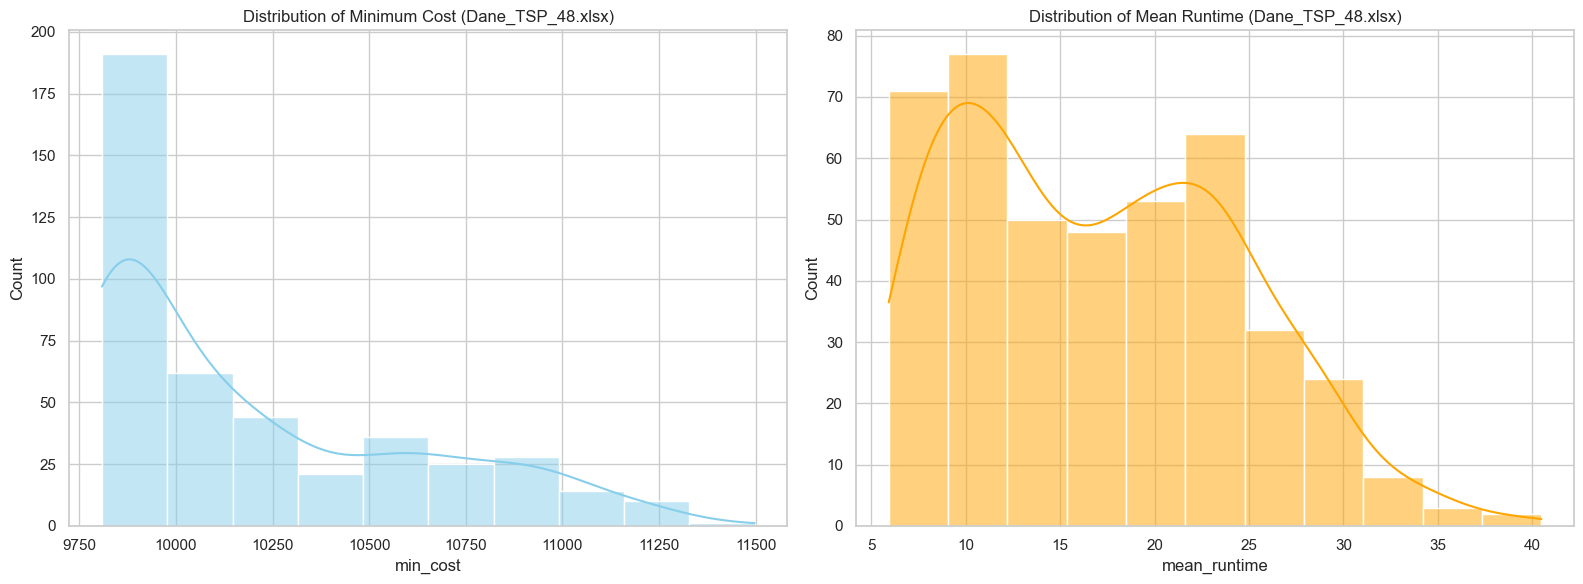


=== Basic Overview: Dane_TSP_76.xlsx ===
Top 10 Configurations by Minimum Cost:


,min_cost,mean_cost,alpha,iterations,ihc_max_iter,mean_runtime
432,98005.629,100165.176,0.4,8000,8000,39.547536
433,98707.825,100513.478,0.2,5000,8000,22.962871
434,98910.344,100164.327,0.8,10000,8000,45.711940
435,99062.688,100142.665,0.2,8000,8000,37.680926
436,99069.816,100073.986,0.6,8000,8000,36.987758
437,99084.767,100734.812,0.8,8000,8000,36.190638
438,99297.172,101645.693,0.2,10000,6000,43.733080
439,99299.948,100286.053,0.4,8000,8000,36.121101
440,99475.916,100156.319,0.2,10000,8000,55.247092
441,99498.197,100611.168,0.4,10000,8000,47.065164


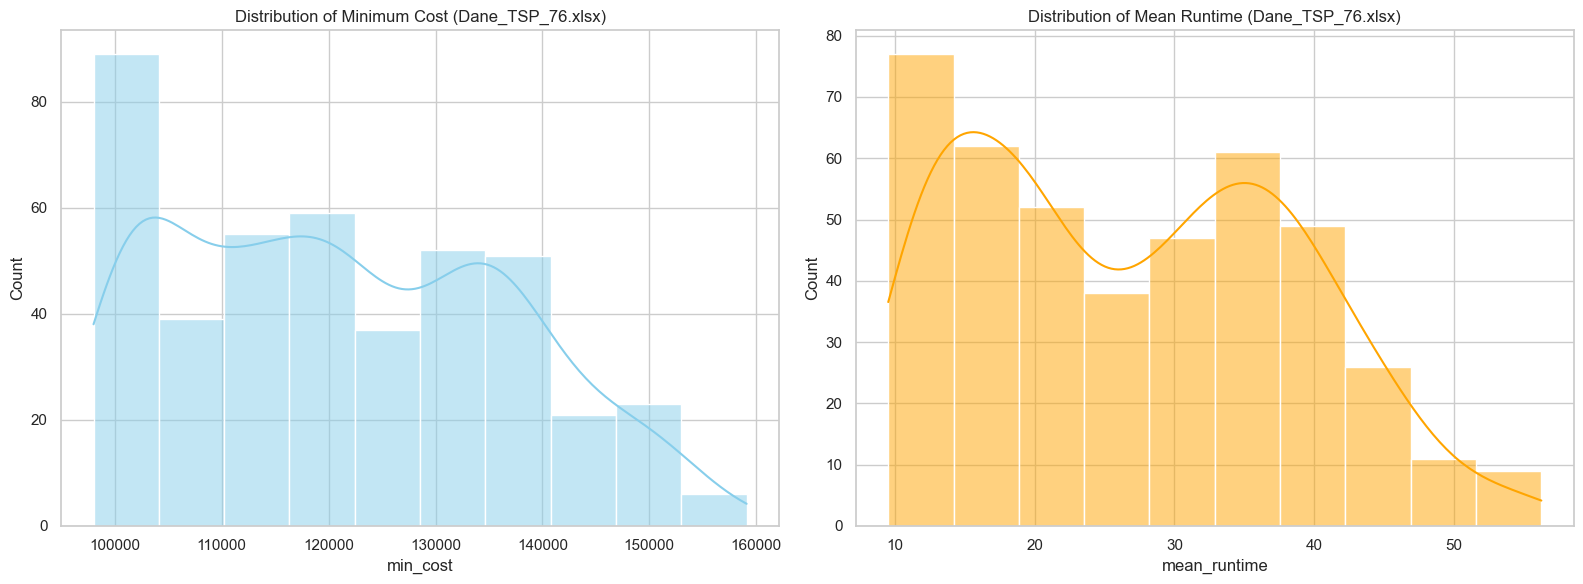


=== Basic Overview: Dane_TSP_127.xlsx ===
Top 10 Configurations by Minimum Cost:


,min_cost,mean_cost,alpha,iterations,ihc_max_iter,mean_runtime
699,126569.002,131436.193,0.2,3000,8000,18.269868
705,127612.694,129905.396,0.2,5000,8000,30.721813
709,127902.739,129954.641,0.2,10000,8000,59.784307
722,129588.221,130876.619,0.2,8000,8000,47.866255
724,129732.681,131391.062,0.2,5000,8000,30.660726
725,129927.499,131321.046,0.2,8000,8000,48.316983
726,129995.135,131065.097,0.2,8000,8000,47.379891
729,130078.213,133790.651,0.4,10000,8000,59.397657
731,130162.503,131319.528,0.2,5000,8000,29.565292
732,130249.479,131973.922,0.2,10000,8000,58.218526


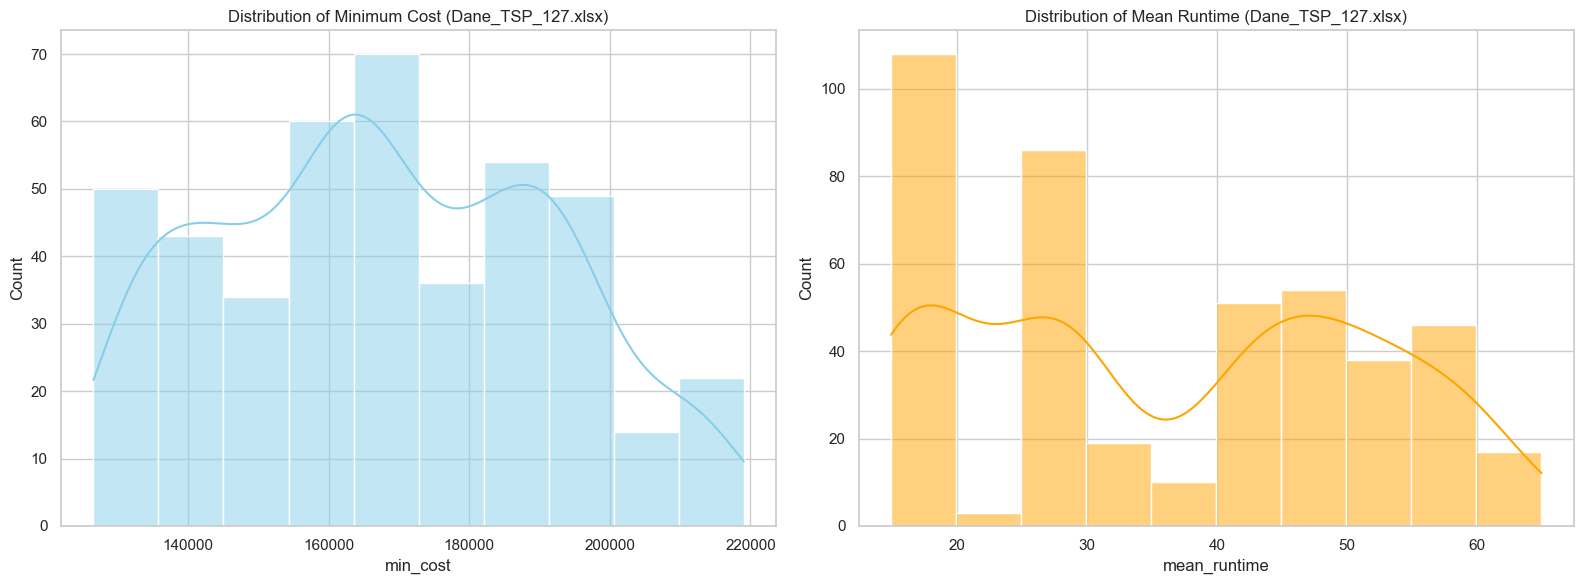

In [11]:
for inst, inst_df in dfs.items():
    print(f"\n=== Basic Overview: {inst} ===")
    if inst_df.empty:
        print("No rows for this dataset.")
        continue

    print("Top 10 Configurations by Minimum Cost:")
    display(inst_df.sort_values('min_cost').head(10)[['min_cost', 'mean_cost', 'alpha', 'iterations', 'ihc_max_iter', 'mean_runtime']])

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(data=inst_df, x='min_cost', kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of Minimum Cost ({inst})')

    sns.histplot(data=inst_df, x='mean_runtime', kde=True, ax=axes[1], color='orange')
    axes[1].set_title(f'Distribution of Mean Runtime ({inst})')

    plt.tight_layout()
    plt.show()

## 3. Option 1: Feature Importance (Random Forest)
We use a Random Forest Regressor to predict `min_cost` based on the algorithm parameters. This helps us understand which parameters have the biggest impact on finding good solutions.


=== Feature Importance (Predicting min_cost) - Dane_TSP_48.xlsx ===


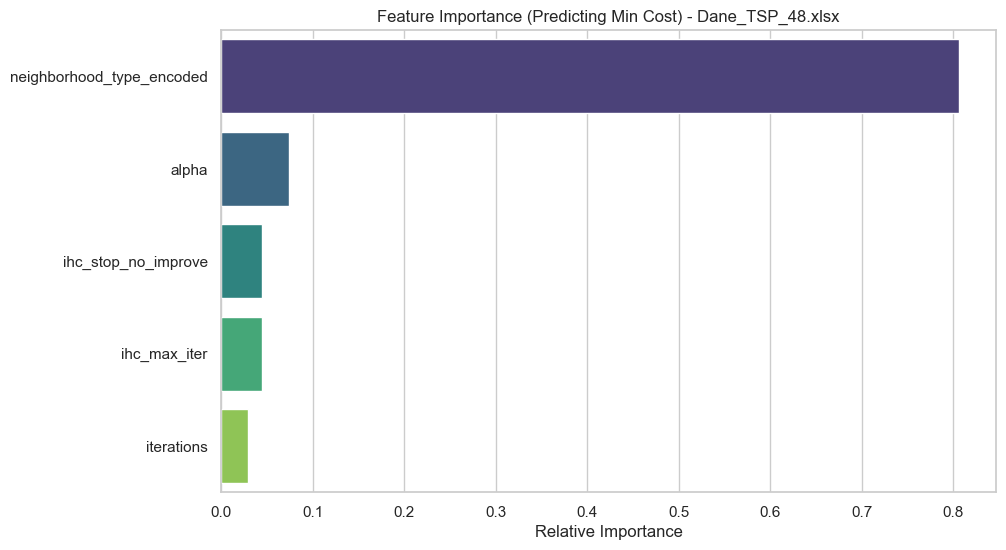


=== Feature Importance (Predicting min_cost) - Dane_TSP_76.xlsx ===


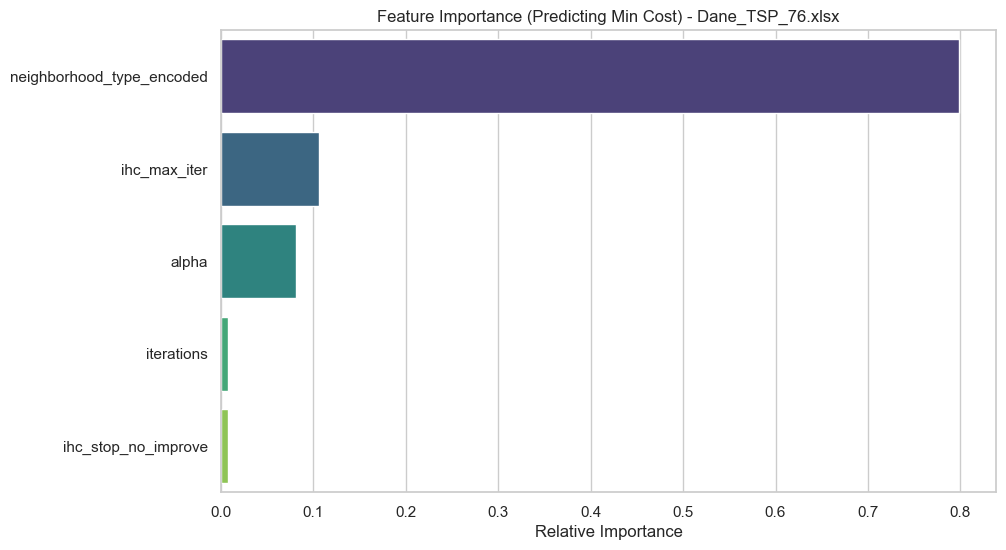


=== Feature Importance (Predicting min_cost) - Dane_TSP_127.xlsx ===


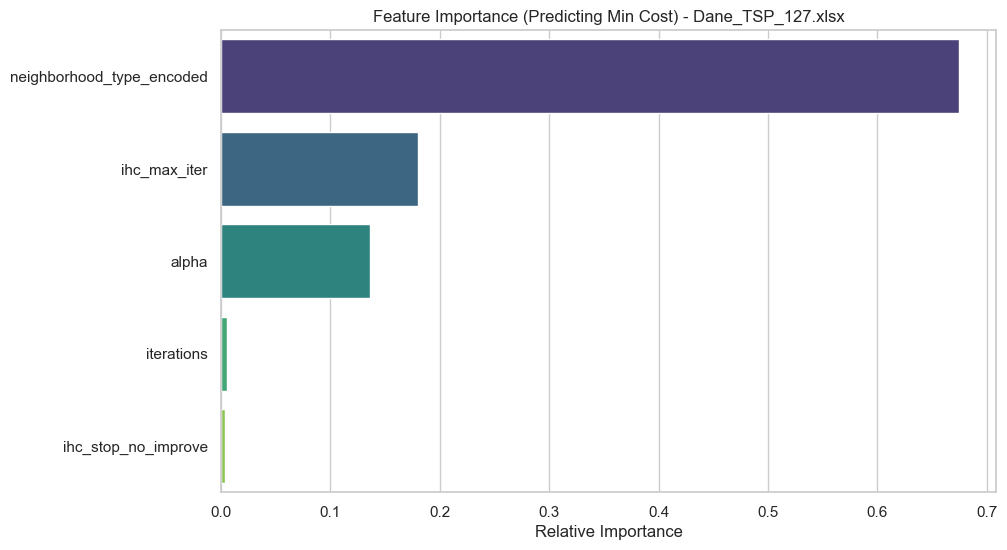

In [12]:
base_features = ['alpha', 'iterations', 'ihc_max_iter', 'ihc_stop_no_improve']
target = 'min_cost'

for inst, inst_df in dfs.items():
    print(f"\n=== Feature Importance (Predicting {target}) - {inst} ===")
    if inst_df.empty:
        print("No rows for this dataset.")
        continue

    rf_df = inst_df.dropna(subset=base_features + [target]).copy()
    if rf_df.empty:
        print("Skipped: insufficient data after dropping missing values.")
        continue

    features = base_features.copy()
    if 'neighborhood_type' in rf_df.columns and rf_df['neighborhood_type'].nunique() > 1:
        le = LabelEncoder()
        rf_df['neighborhood_type_encoded'] = le.fit_transform(rf_df['neighborhood_type'])
        features.append('neighborhood_type_encoded')

    if len(rf_df) < 2 or rf_df[target].nunique() < 2:
        print("Skipped: not enough variation to train the model.")
        continue

    X = rf_df[features]
    y = rf_df[target]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    ordered_features = [features[i] for i in indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=importances[indices],
        y=ordered_features,
        hue=ordered_features,
        palette='viridis',
        dodge=False,
        legend=False,
    )
    plt.title(f'Feature Importance (Predicting Min Cost) - {inst}')
    plt.xlabel('Relative Importance')
    plt.show()

## 4. Option 2: Pareto Efficiency Frontier
We visualize the trade-off between Solution Quality (`min_cost`) and Computational Cost (`mean_runtime`). Points on the lower-left boundary represent the most efficient configurations.

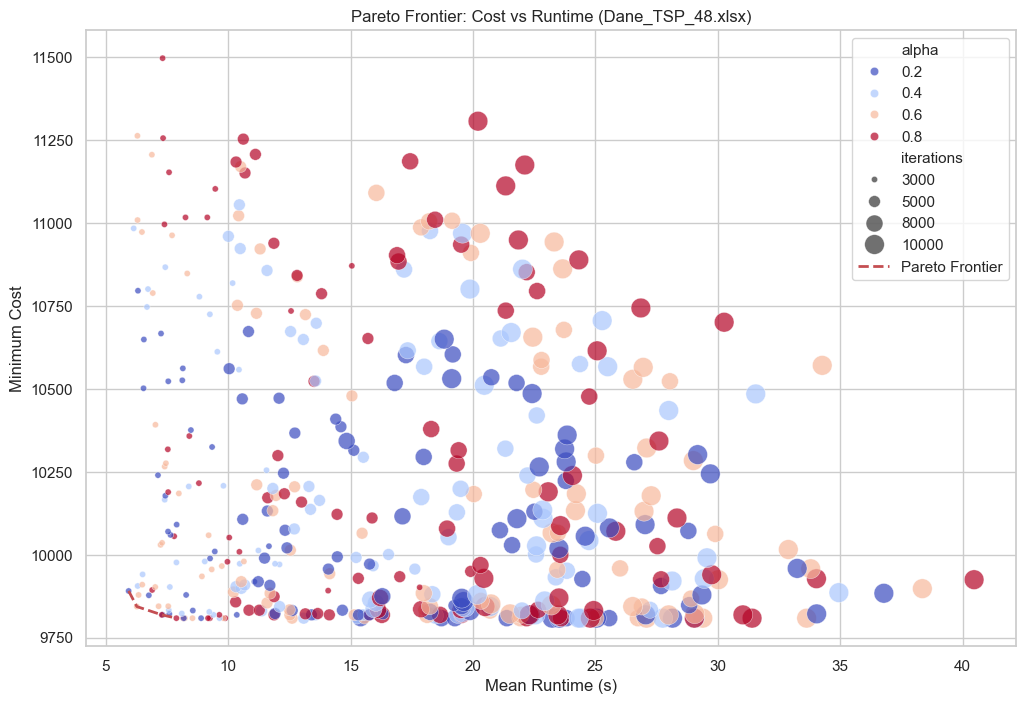

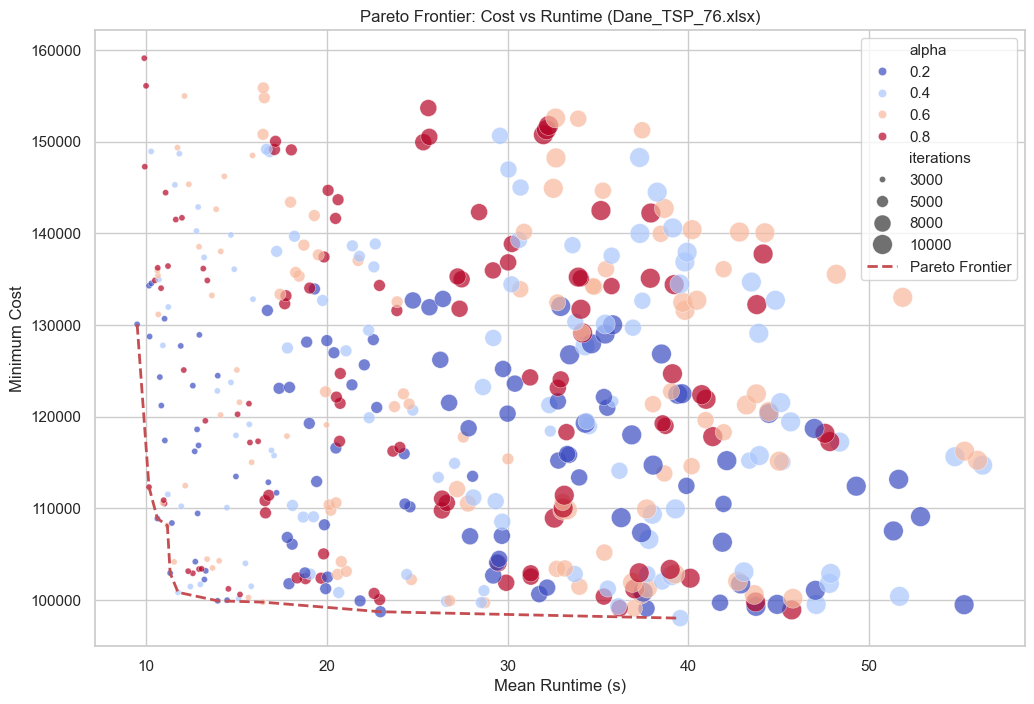

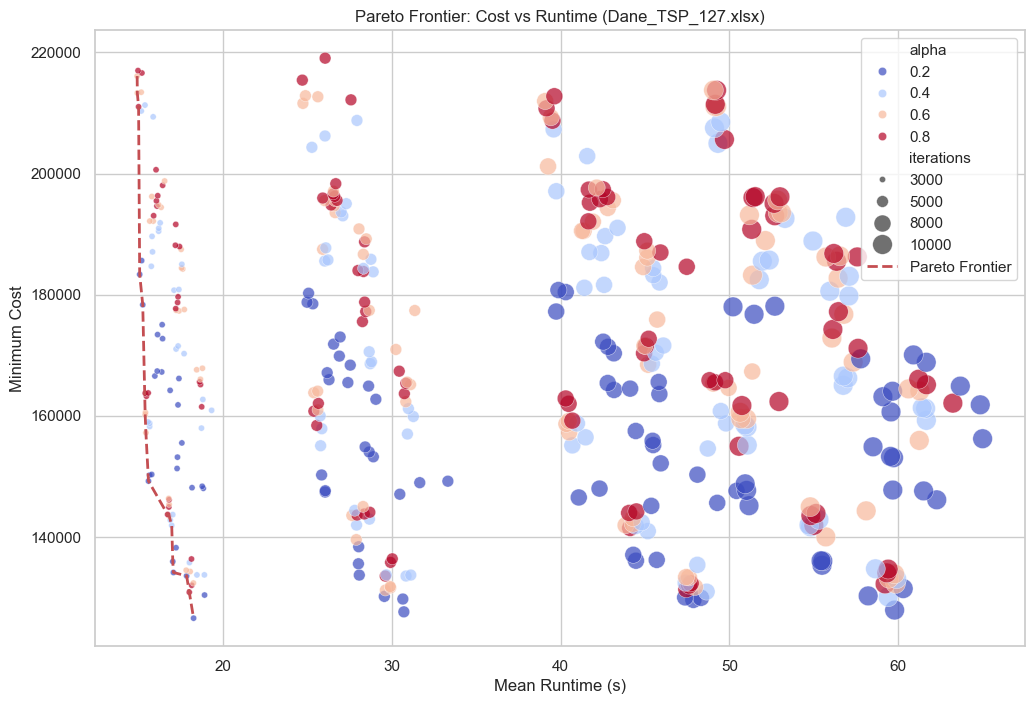

In [13]:
for inst, inst_df in dfs.items():
    if inst_df.empty:
        print(f"Skipped Pareto Frontier: no rows for {inst}.")
        continue

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=inst_df,
        x='mean_runtime',
        y='min_cost',
        hue='alpha',
        palette='coolwarm',
        size='iterations',
        sizes=(20, 200),
        alpha=0.7,
    )

    sorted_df = inst_df.sort_values('mean_runtime')
    pareto_front = []
    current_min_cost = float('inf')

    for _, row in sorted_df.iterrows():
        if row['min_cost'] < current_min_cost:
            pareto_front.append(row)
            current_min_cost = row['min_cost']

    pareto_df = pd.DataFrame(pareto_front)
    if not pareto_df.empty:
        plt.plot(pareto_df['mean_runtime'], pareto_df['min_cost'], 'r--', label='Pareto Frontier', linewidth=2)

    plt.title(f'Pareto Frontier: Cost vs Runtime ({inst})')
    plt.xlabel('Mean Runtime (s)')
    plt.ylabel('Minimum Cost')
    plt.legend()
    plt.show()

## 5. Option 3: Parameter Interaction Heatmaps
We explore how two parameters interact to affect the cost. We look at:
- Alpha vs Iterations
- Alpha vs IHC Max Iter
- Iterations vs IHC Max Iter


=== Parameter Interaction Heatmaps (Dane_TSP_48.xlsx) ===


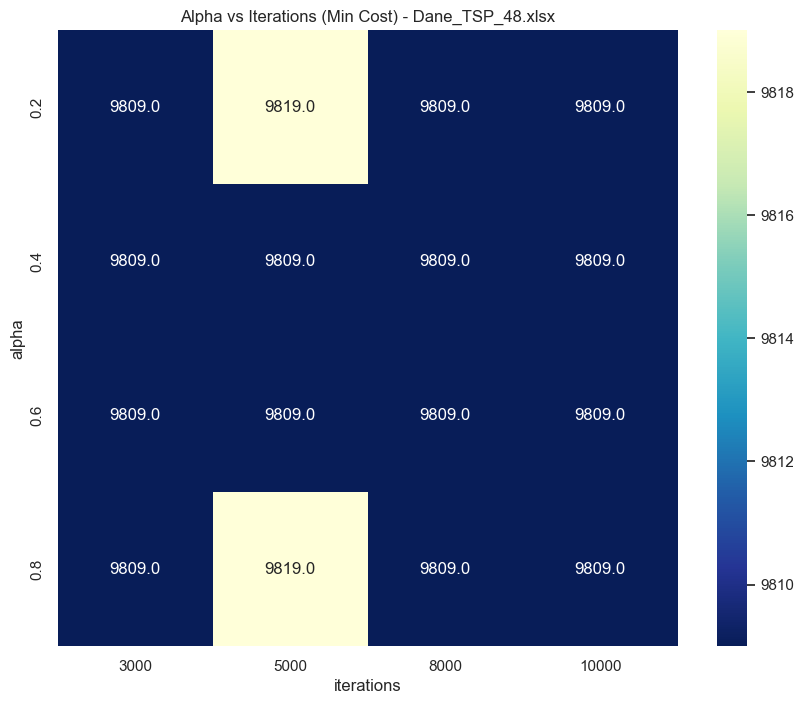

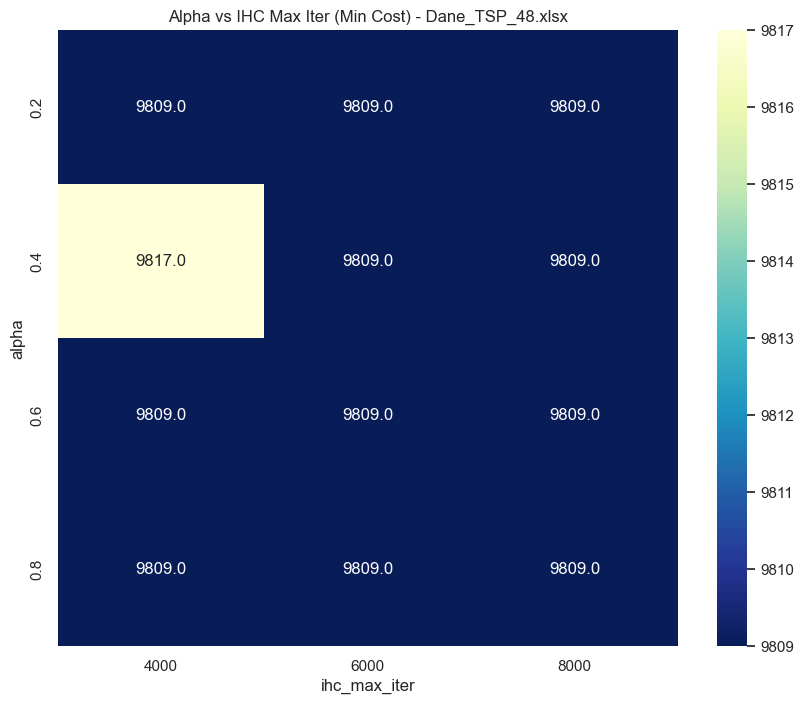

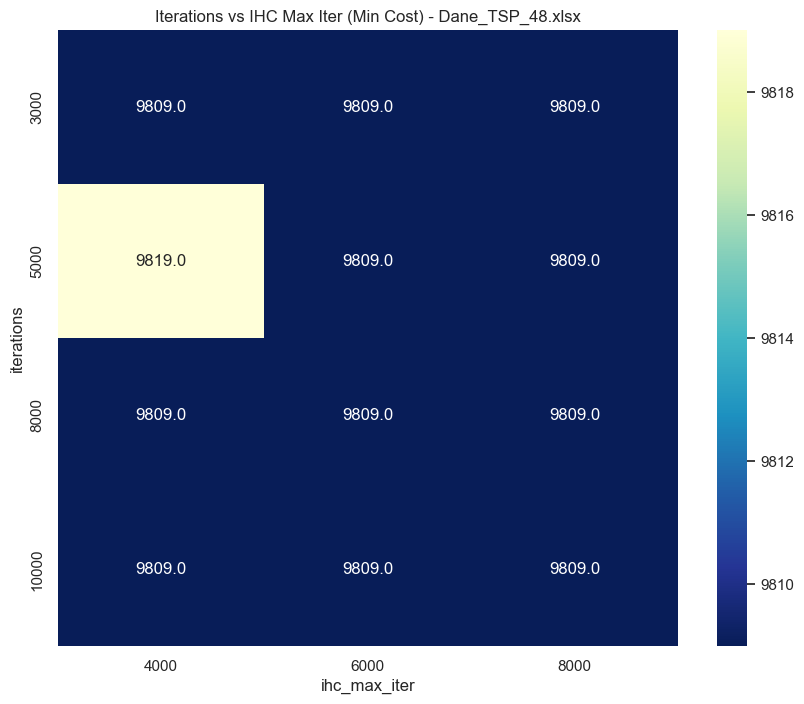


=== Parameter Interaction Heatmaps (Dane_TSP_76.xlsx) ===


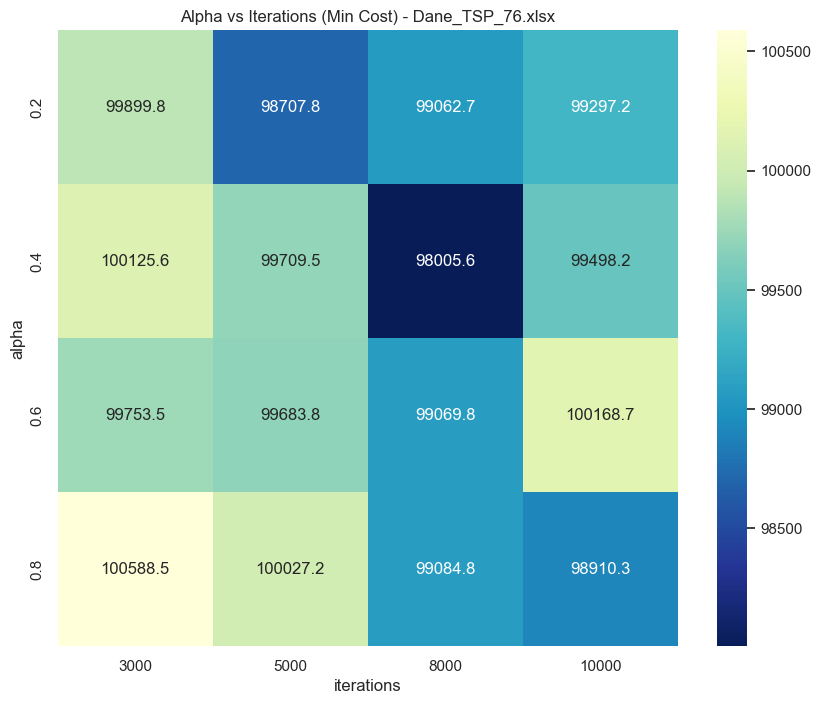

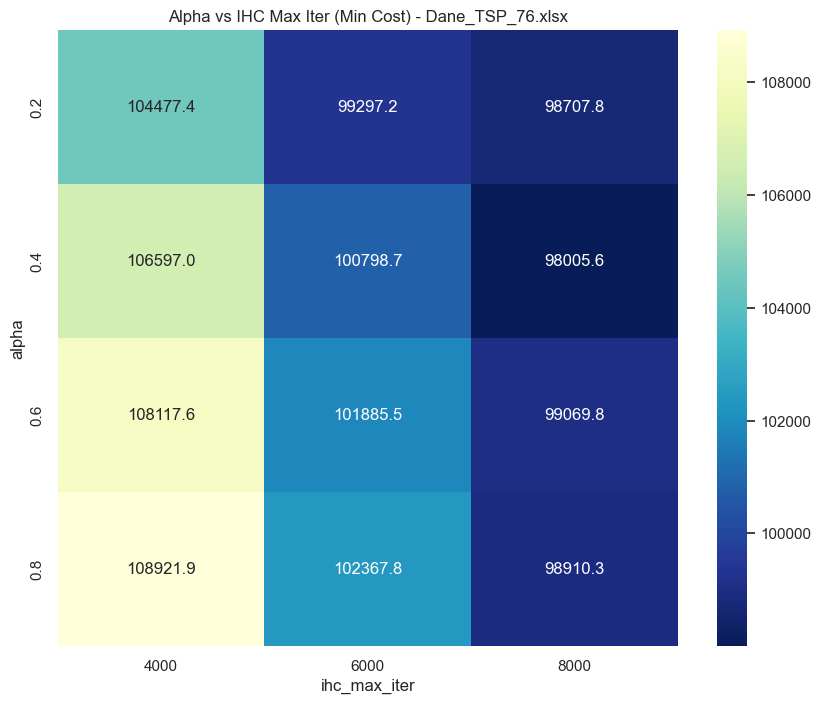

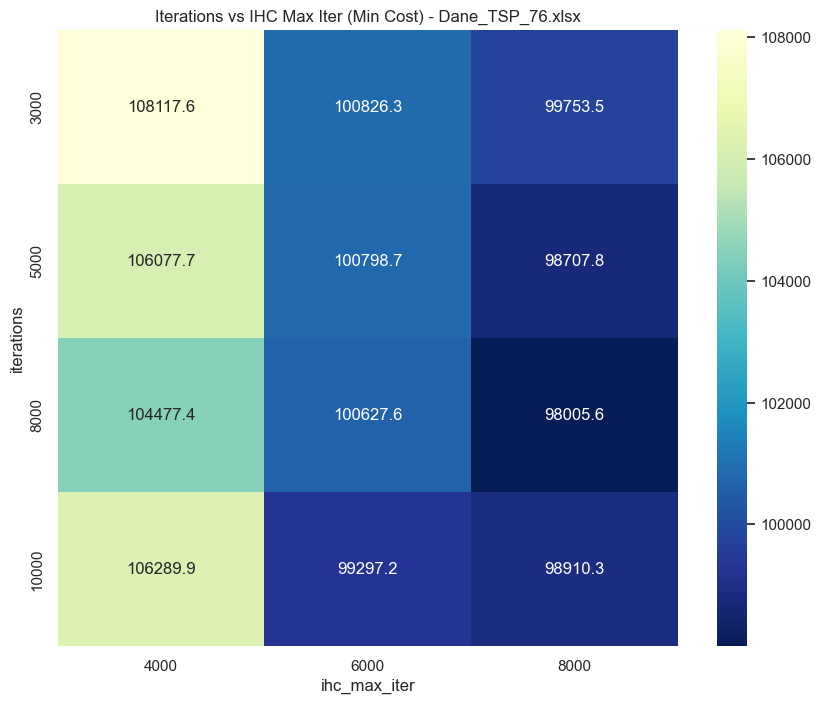


=== Parameter Interaction Heatmaps (Dane_TSP_127.xlsx) ===


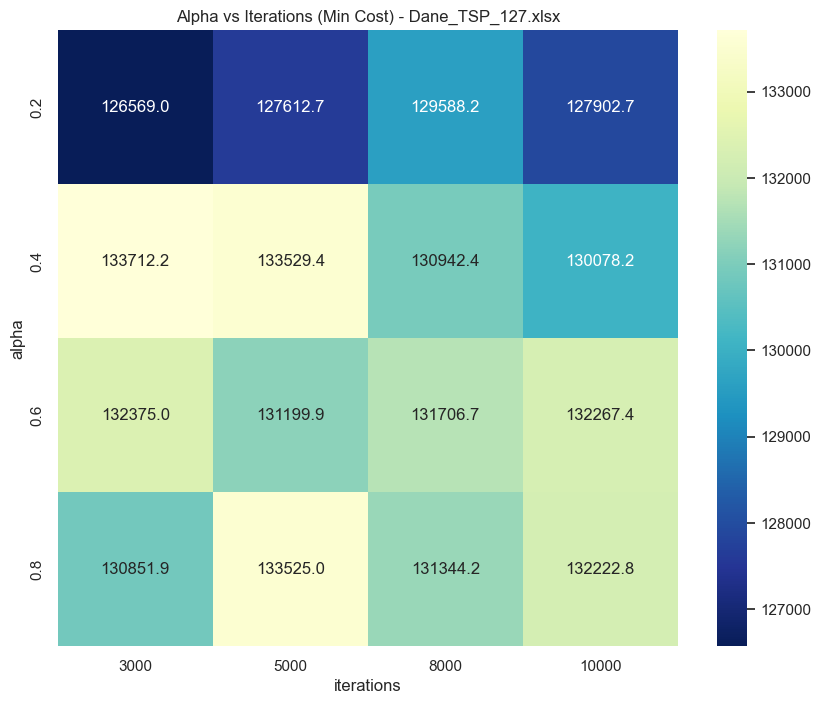

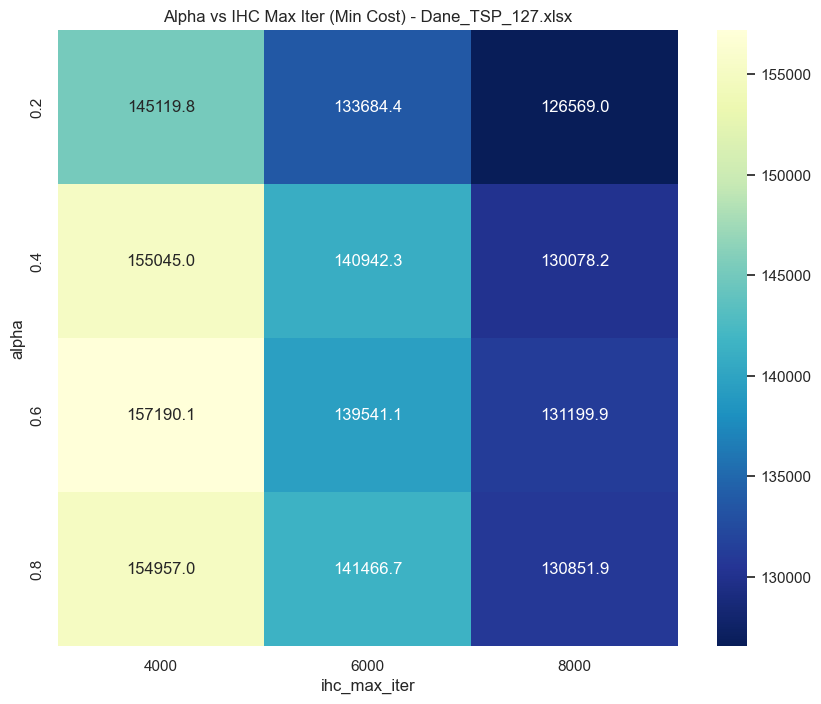

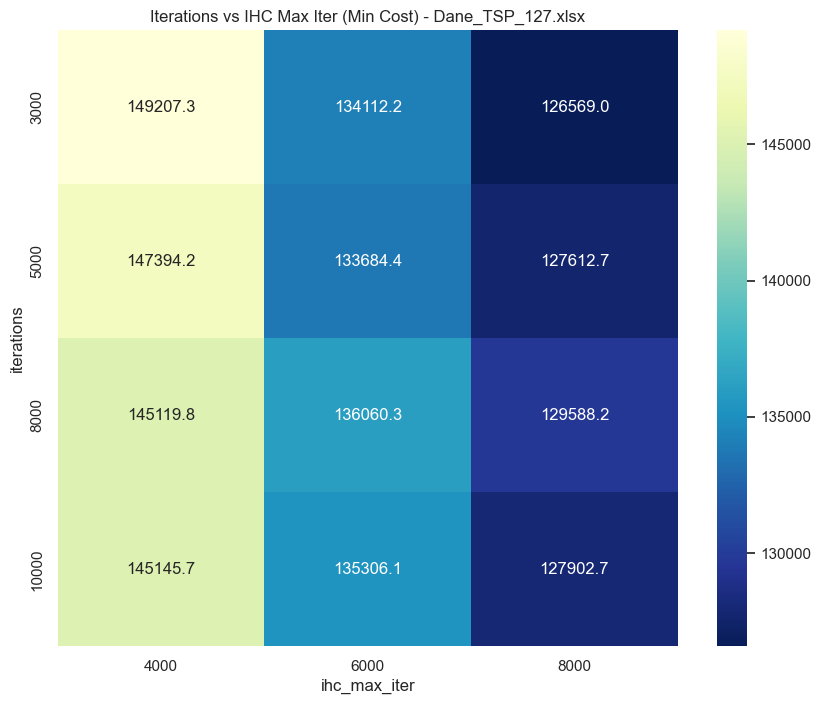

In [14]:
for inst, inst_df in dfs.items():
    print(f"\n=== Parameter Interaction Heatmaps ({inst}) ===")
    if inst_df.empty:
        print("No data to visualize.")
        continue

    if {'alpha', 'iterations', 'min_cost'}.issubset(inst_df.columns):
        pivot_table = inst_df.pivot_table(values='min_cost', index='alpha', columns='iterations', aggfunc='min')
        if pivot_table.empty:
            print("No values available for Alpha vs Iterations heatmap.")
        else:
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu_r")
            plt.title(f'Alpha vs Iterations (Min Cost) - {inst}')
            plt.show()
    else:
        print("Missing columns for Alpha vs Iterations heatmap.")

    if {'alpha', 'ihc_max_iter', 'min_cost'}.issubset(inst_df.columns):
        pivot_table2 = inst_df.pivot_table(values='min_cost', index='alpha', columns='ihc_max_iter', aggfunc='min')
        if pivot_table2.empty:
            print("No values available for Alpha vs IHC Max Iter heatmap.")
        else:
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_table2, annot=True, fmt=".1f", cmap="YlGnBu_r")
            plt.title(f'Alpha vs IHC Max Iter (Min Cost) - {inst}')
            plt.show()
    else:
        print("Missing columns for Alpha vs IHC Max Iter heatmap.")

    if {'iterations', 'ihc_max_iter', 'min_cost'}.issubset(inst_df.columns):
        pivot_table3 = inst_df.pivot_table(values='min_cost', index='iterations', columns='ihc_max_iter', aggfunc='min')
        if pivot_table3.empty:
            print("No values available for Iterations vs IHC Max Iter heatmap.")
        else:
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_table3, annot=True, fmt=".1f", cmap="YlGnBu_r")
            plt.title(f'Iterations vs IHC Max Iter (Min Cost) - {inst}')
            plt.show()
    else:
        print("Missing columns for Iterations vs IHC Max Iter heatmap.")

## 6. Option 4: Solution Diversity Analysis
We analyze the `min_route` column to see how different the best solutions are. We calculate the Jaccard similarity of edges between the top solutions.


=== Solution Diversity (Top 20) - Dane_TSP_48.xlsx ===


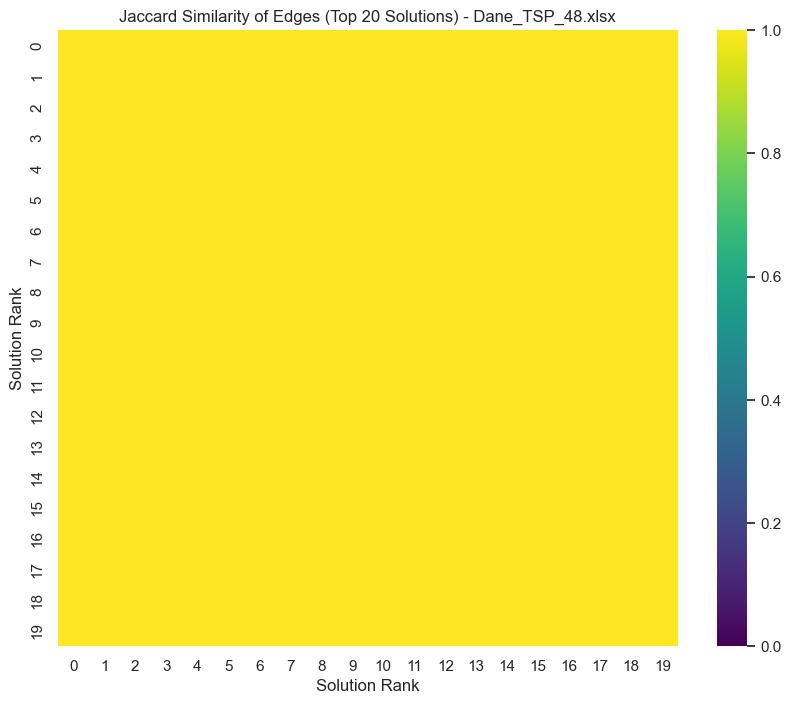


=== Solution Diversity (Top 20) - Dane_TSP_76.xlsx ===


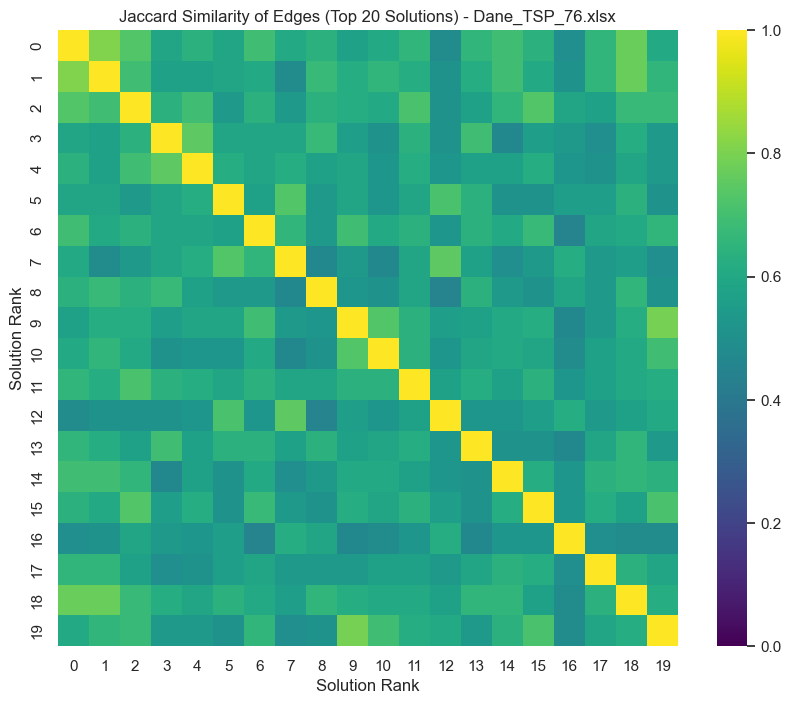


=== Solution Diversity (Top 20) - Dane_TSP_127.xlsx ===


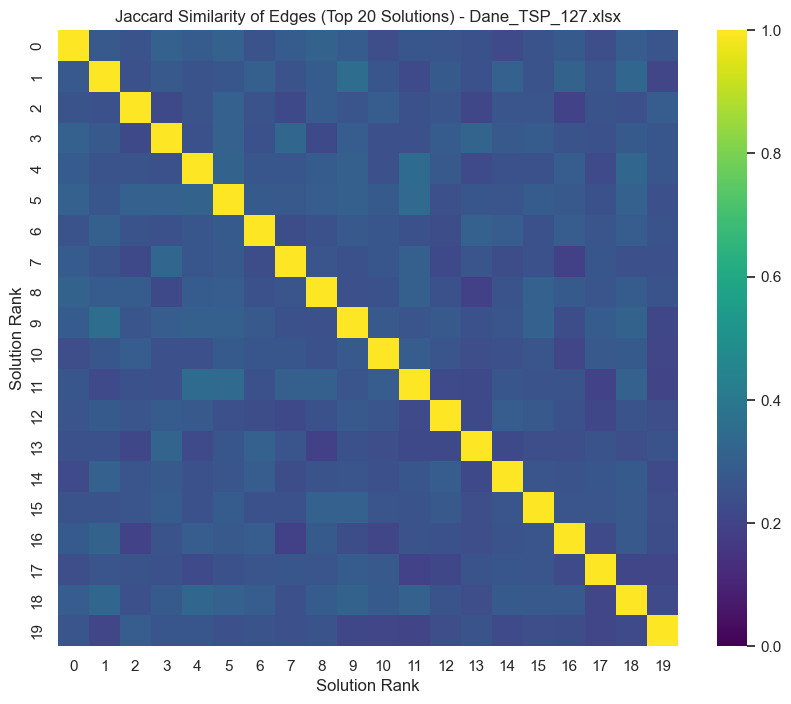

In [15]:
def parse_route(route_str):
    # Assumes route is like "0-4-26-35..."
    if not isinstance(route_str, str):
        return set()
    nodes = route_str.split('-')
    edges = set()
    for i in range(len(nodes) - 1):
        u, v = sorted((nodes[i], nodes[i + 1]))
        edges.add(f"{u}-{v}")
    # Add return to start edge if TSP
    if len(nodes) > 1:
        u, v = sorted((nodes[-1], nodes[0]))
        edges.add(f"{u}-{v}")
    return edges

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

for inst, inst_df in dfs.items():
    print(f"\n=== Solution Diversity (Top 20) - {inst} ===")
    if inst_df.empty:
        print("No data available.")
        continue

    top_solutions = inst_df.sort_values('min_cost').head(20).copy()
    if top_solutions.empty or top_solutions['min_route'].isna().all():
        print("Skipped: no valid routes to compare.")
        continue

    top_solutions['edges'] = top_solutions['min_route'].apply(parse_route)
    n = len(top_solutions)
    if n < 2:
        print("Skipped: need at least two routes to compare diversity.")
        continue

    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = jaccard_similarity(top_solutions.iloc[i]['edges'], top_solutions.iloc[j]['edges'])

    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, cmap='viridis', vmin=0, vmax=1)
    plt.title(f'Jaccard Similarity of Edges (Top 20 Solutions) - {inst}')
    plt.xlabel('Solution Rank')
    plt.ylabel('Solution Rank')
    plt.show()

## 7. Option 5: Statistical Significance Tests
We perform the Kruskal-Wallis H-test to determine if the differences in `min_cost` across different parameter groups are statistically significant.

In [16]:
def test_significance(inst_name, inst_df, param):
    if param not in inst_df.columns:
        print(f"{param}: column not found in {inst_name}.")
        return

    values = inst_df[param].dropna().unique()
    if len(values) < 2:
        print(f"{param}: skipped for {inst_name} (need at least two distinct values).")
        return

    groups = [inst_df[inst_df[param] == v]['min_cost'] for v in values]
    if any(len(g) == 0 for g in groups):
        print(f"{param}: skipped for {inst_name} (insufficient samples per group).")
        return

    stat, p = stats.kruskal(*groups)
    print(f"Kruskal-Wallis Test for {param} ({inst_name}):")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value: {p:.4e}")
    if p < 0.05:
        print("  Result: Significant difference found (p < 0.05)")
    else:
        print("  Result: No significant difference found")
    print("-" * 30)

for inst, inst_df in dfs.items():
    print(f"\n=== Statistical Significance - {inst} ===")
    if inst_df.empty:
        print("No data available.")
        continue

    for param in ['alpha', 'iterations', 'ihc_max_iter']:
        test_significance(inst, inst_df, param)


=== Statistical Significance - Dane_TSP_48.xlsx ===
Kruskal-Wallis Test for alpha (Dane_TSP_48.xlsx):
  Statistic: 4.3751
  p-value: 2.2370e-01
  Result: No significant difference found
------------------------------
Kruskal-Wallis Test for iterations (Dane_TSP_48.xlsx):
  Statistic: 2.1909
  p-value: 5.3375e-01
  Result: No significant difference found
------------------------------
Kruskal-Wallis Test for ihc_max_iter (Dane_TSP_48.xlsx):
  Statistic: 11.6212
  p-value: 2.9957e-03
  Result: Significant difference found (p < 0.05)
------------------------------

=== Statistical Significance - Dane_TSP_76.xlsx ===
Kruskal-Wallis Test for alpha (Dane_TSP_76.xlsx):
  Statistic: 19.7430
  p-value: 1.9188e-04
  Result: Significant difference found (p < 0.05)
------------------------------
Kruskal-Wallis Test for iterations (Dane_TSP_76.xlsx):
  Statistic: 0.9241
  p-value: 8.1960e-01
  Result: No significant difference found
------------------------------
Kruskal-Wallis Test for ihc_max_it